### Install desigal package (assuming all other desi packages are installed)

In [1]:
## Installation for use
# !pip install --user git+https://github.com/desihub/desigal.git#egg=desigal

In [2]:
# # installation for development
# !git clone https://github.com/desihub/desigal
# %cd ../..
# !pip install --user --editable .

In [3]:
%load_ext autoreload
%autoreload 2

# Tutorial on stacking DESI spectra
This is a quick (two step) tutorial on the DESI spectral stacking pipeline

In [4]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
#import desigal.specutils

# To be removed later. Notebook created before updates are on the main desigal version.
sys.path.insert(0,'../../py')
import desigal_local.specutils 

### Start with your favorite target ids

In [5]:
targets = [39627652591526038, 39627646576885987] # LRGS
z_targets = [0.3313666995460735, 0.3757204903818251]

# targets = [39627646576885924, 39627640566454233] # QSO
# z_targets = [0.47741841167195725, 0.7193102969415338]


### Load the spectra

In [6]:
spectra = desigal_local.specutils.get_spectra(targets, release="fuji", n_workers=6, use_db = True)

INFO:spectra.py:291:read_spectra: iotime 0.332 sec to read coadd-sv1-dark-17682.fits at 2023-04-13T03:50:28.950283


2023-04-13 03:50:28,950 desiutil.log.dlm58.info INFO : iotime 0.332 sec to read coadd-sv1-dark-17682.fits at 2023-04-13T03:50:28.950283


INFO:spectra.py:291:read_spectra: iotime 0.692 sec to read coadd-sv1-dark-17683.fits at 2023-04-13T03:50:29.266919


2023-04-13 03:50:29,266 desiutil.log.dlm58.info INFO : iotime 0.692 sec to read coadd-sv1-dark-17683.fits at 2023-04-13T03:50:29.266919


### Pretty Spectra!

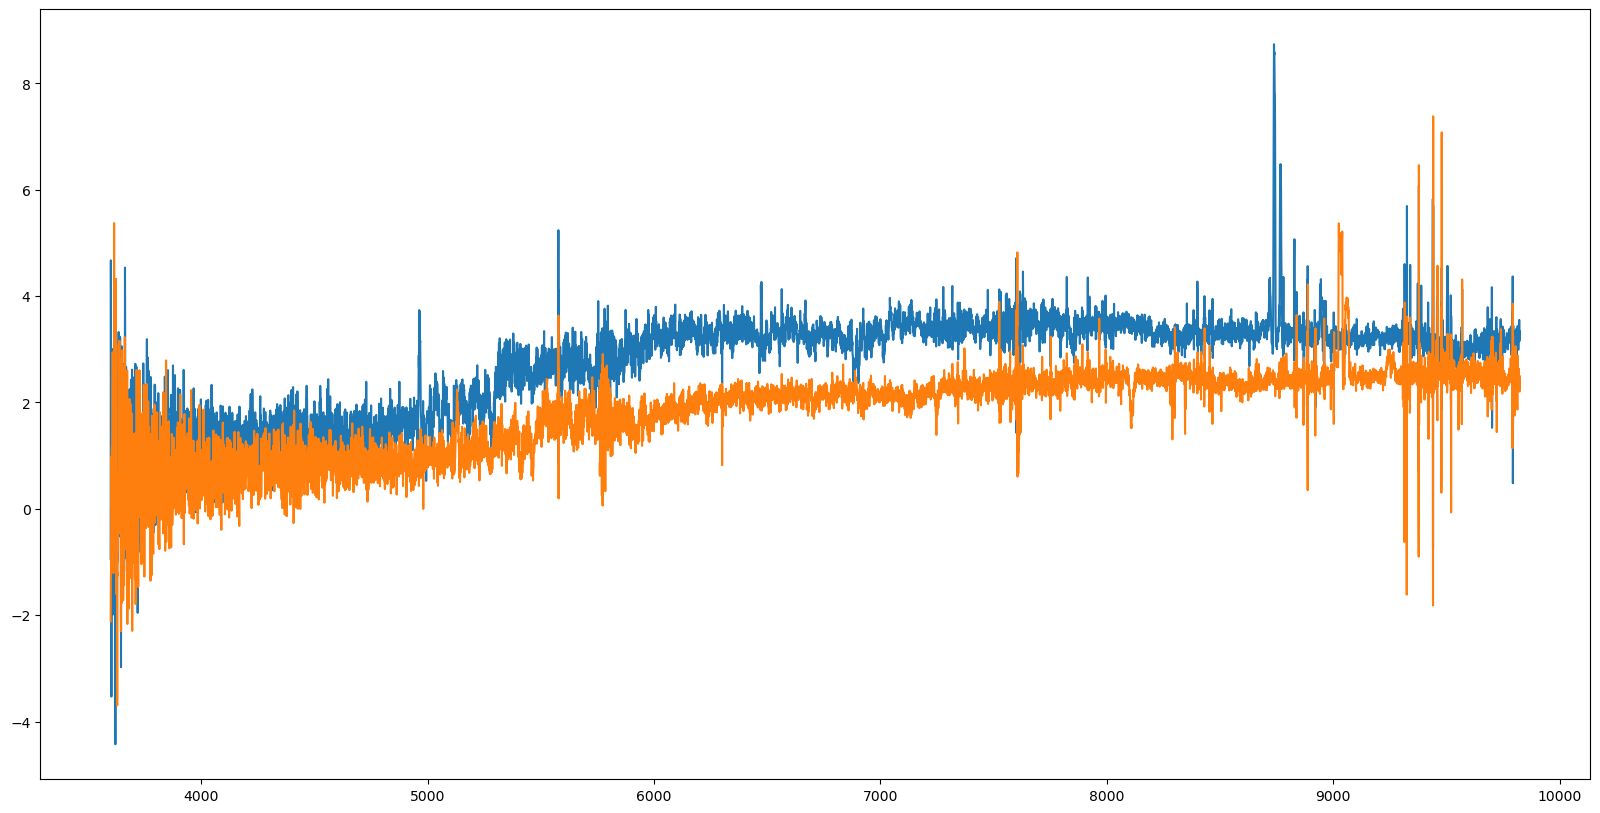

In [7]:
plt.figure(figsize=(20,10))
for idx in range(spectra.num_spectra()):
    for cam in spectra.bands:
        plt.plot(spectra.wave[cam], spectra.flux[cam][idx], c= f"C{idx}")

### Stack Spectra

In [8]:
stacked_spectra, stack_grid = desigal_local.specutils.stack_spectra(
                                spectra,
                                redshift=np.array(z_targets),
                                norm_method = "flux-window", #"mean", "median", "flux-window"
                                norm_flux_window=[4000,4050],
                                resample_resolution=0.4,
                                resample_method = "linear", #"linear", "sn-cons", "flux-cons"    
                                stack_method = "ivar-weighted-mean", #median , mean
                                n_workers =6,
                                bootstrap=True
                               )

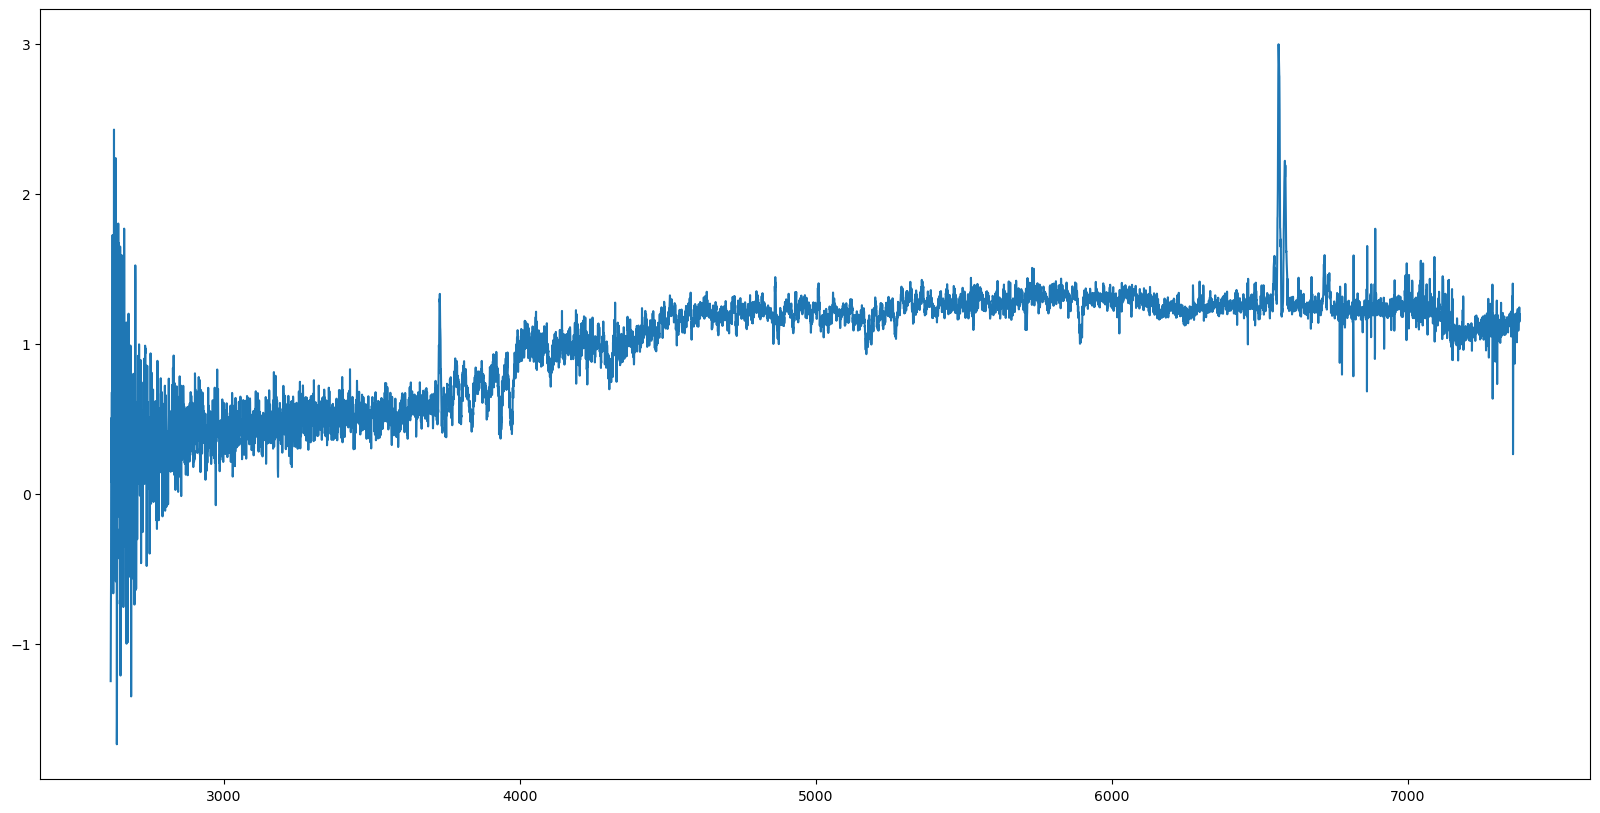

In [9]:
plt.figure(figsize=(20,10))
plt.plot(stack_grid, stacked_spectra[0])


### Save stacks

In [10]:
# Again we specify our targets and target redshifts. Now we specify targets as a 2D array where the 1st dimension separates different stacks.
targets = np.array([[39627757549781521, 39627758099238740, 39627758099238859,
                     39627758099238900, 39627758099238931, 39627758099238954,
                     39627763589580784, 39627763589580845, 39627763589581033,
                     39627763589581231, 39627763589581368, 39627763589581441,
                     39627763589581458, 39627770296276438, 39627775715316324,
                     39627776264767718, 39627776264767836, 39627776264767942,
                     39627776264768321, 39627776264768455],
                    [39627733935850977, 39627733986182919, 39627734002962702,
                     39627734053290437, 39627734057488720, 39627739963067940,
                     39627739963068401, 39627739963068532, 39627739971454580,
                     39627739975648525, 39627739979842315, 39627739979846602,
                     39627739984041008, 39627739988233491, 39627739992425384,
                     39627739992425596, 39627740021789546, 39627740030174973,
                     39627740034372667, 39627740042761616]])
z_targets = np.array([[0.00549467, 0.00478984, 0.00488709, 0.00545382, 0.00549349,
                       0.00545548, 0.00442916, 0.00438678, 0.00492025, 0.00542517,
                       0.00478803, 0.00476095, 0.00506013, 0.00611871, 0.00386091,
                       0.00545443, 0.0054151 , 0.00540271, 0.00533975, 0.00535535],
                      [0.16558725, 0.12689658, 0.12684531, 0.13816829, 0.1404767 ,
                       0.15193659, 0.15115597, 0.15135542, 0.13045069, 0.13771661,
                       0.11968457, 0.13789992, 0.15994504, 0.14996304, 0.12467965,
                       0.14920402, 0.13148009, 0.13882322, 0.14609249, 0.13914802]])

In [11]:
n_stacks = len(targets)

# Specify the wavelength grid
wave_new = np.arange(3000,9800, step=0.4)

# Specify flux, ivar arrays to save the stacks
stacked_flux = np.zeros((n_stacks, len(wave_new)))
stacked_ivar = np.zeros((n_stacks, len(wave_new)))

# Specify the columns that we want to save along with the stacks
# STACKID and Z are saved separately as they are mandatory columns
table_column_dict = {'TARGETIDS':np.zeros((n_stacks,1)).tolist(), 
                     'TARGET_Z':np.zeros((n_stacks,1)).tolist(), 
                     'NOBJ':np.zeros((n_stacks)).tolist()
                    }
table_format_dict = {'TARGETIDS':'PK()', 
                     'TARGET_Z':'PD()', 
                     'NOBJ':'K'
                    }

# Create the stacks
for i in range(n_stacks):
    targetid_list = [int(target) for target in targets[i]]
    redshift = z_targets[i]
        
    spectra = desigal_local.specutils.get_spectra(targetid_list, release="fuji", n_workers=6, use_db = True)
    
    stacked_spectrum, stack_wave = desigal_local.specutils.stack.stack_spectra(
                                    spectra,
                                    redshift=redshift,
                                    norm_method = "flux-window", #"mean", "median", "flux-window"
                                    norm_flux_window=[4000,4050],
                                    resample_method = "linear",
                                    stack_method = "ivar-weighted-mean", #median , ivar
                                    n_workers = 6,
                                    output_wave_grid=wave_new,
                                    bootstrap=True
                                   )
    
    if np.all(stacked_flux == None):
        stacked_flux = np.zeros((n_stacks, len(stack_wave)))
        stacked_ivar = np.zeros((n_stacks, len(stack_wave)))

    stacked_flux[i] = stacked_spectrum[0]
    stacked_ivar[i] = stacked_spectrum[1]
    
    stacked_flux[np.isnan(stacked_flux)|np.isnan(stacked_ivar)] = 0.0
    stacked_ivar[np.isnan(stacked_flux)|np.isnan(stacked_ivar)] = 0.0
    
# Save the stacks    
desigal_local.specutils.stack.write_binned_stacks('example_stack.fits', 
                                                  wave_new, 
                                                  stacked_flux, 
                                                  stacked_ivar,
                                                  table_column_dict = table_column_dict,
                                                  table_format_dict = table_format_dict
                                                 )

INFO:spectra.py:291:read_spectra: iotime 0.394 sec to read coadd-sv3-bright-25596.fits at 2023-04-13T03:50:33.732062


2023-04-13 03:50:33,732 desiutil.log.dlm58.info INFO : iotime 0.394 sec to read coadd-sv3-bright-25596.fits at 2023-04-13T03:50:33.732062


INFO:spectra.py:291:read_spectra: iotime 1.366 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.704683
INFO:spectra.py:291:read_spectra: iotime 1.443 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.781880
INFO:spectra.py:291:read_spectra: iotime 1.452 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.790619
INFO:spectra.py:291:read_spectra: iotime 1.456 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.794914
INFO:spectra.py:291:read_spectra: iotime 1.491 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.828884


2023-04-13 03:50:34,704 desiutil.log.dlm58.info INFO : iotime 1.366 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.704683
2023-04-13 03:50:34,781 desiutil.log.dlm58.info INFO : iotime 1.443 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.781880
2023-04-13 03:50:34,790 desiutil.log.dlm58.info INFO : iotime 1.452 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.790619
2023-04-13 03:50:34,794 desiutil.log.dlm58.info INFO : iotime 1.456 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.794914
2023-04-13 03:50:34,828 desiutil.log.dlm58.info INFO : iotime 1.491 sec to read coadd-sv3-bright-25918.fits at 2023-04-13T03:50:34.828884


INFO:spectra.py:291:read_spectra: iotime 2.284 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:36.348396


2023-04-13 03:50:36,348 desiutil.log.dlm58.info INFO : iotime 2.284 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:36.348396


INFO:spectra.py:291:read_spectra: iotime 0.991 sec to read coadd-sv3-bright-25597.fits at 2023-04-13T03:50:37.156752
INFO:spectra.py:291:read_spectra: iotime 0.976 sec to read coadd-sv3-bright-25597.fits at 2023-04-13T03:50:37.157587


2023-04-13 03:50:37,156 desiutil.log.dlm58.info INFO : iotime 0.991 sec to read coadd-sv3-bright-25597.fits at 2023-04-13T03:50:37.156752
2023-04-13 03:50:37,157 desiutil.log.dlm58.info INFO : iotime 0.976 sec to read coadd-sv3-bright-25597.fits at 2023-04-13T03:50:37.157587


INFO:spectra.py:291:read_spectra: iotime 1.522 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:37.542362
INFO:spectra.py:291:read_spectra: iotime 1.590 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:37.720208


2023-04-13 03:50:37,542 desiutil.log.dlm58.info INFO : iotime 1.522 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:37.542362
2023-04-13 03:50:37,720 desiutil.log.dlm58.info INFO : iotime 1.590 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:37.720208


INFO:spectra.py:291:read_spectra: iotime 1.606 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:37.744804


2023-04-13 03:50:37,744 desiutil.log.dlm58.info INFO : iotime 1.606 sec to read coadd-sv3-bright-25599.fits at 2023-04-13T03:50:37.744804


INFO:spectra.py:291:read_spectra: iotime 0.697 sec to read coadd-sv3-bright-25597.fits at 2023-04-13T03:50:38.464328


2023-04-13 03:50:38,464 desiutil.log.dlm58.info INFO : iotime 0.697 sec to read coadd-sv3-bright-25597.fits at 2023-04-13T03:50:38.464328


INFO:spectra.py:291:read_spectra: iotime 2.425 sec to read coadd-sv3-bright-26275.fits at 2023-04-13T03:50:40.341288
INFO:spectra.py:291:read_spectra: iotime 2.540 sec to read coadd-sv3-bright-25933.fits at 2023-04-13T03:50:40.449030


2023-04-13 03:50:40,341 desiutil.log.dlm58.info INFO : iotime 2.425 sec to read coadd-sv3-bright-26275.fits at 2023-04-13T03:50:40.341288
2023-04-13 03:50:40,449 desiutil.log.dlm58.info INFO : iotime 2.540 sec to read coadd-sv3-bright-25933.fits at 2023-04-13T03:50:40.449030


INFO:spectra.py:291:read_spectra: iotime 1.620 sec to read coadd-sv3-bright-25960.fits at 2023-04-13T03:50:40.570028
INFO:spectra.py:291:read_spectra: iotime 1.446 sec to read coadd-sv3-bright-25960.fits at 2023-04-13T03:50:40.593314


2023-04-13 03:50:40,570 desiutil.log.dlm58.info INFO : iotime 1.620 sec to read coadd-sv3-bright-25960.fits at 2023-04-13T03:50:40.570028
2023-04-13 03:50:40,593 desiutil.log.dlm58.info INFO : iotime 1.446 sec to read coadd-sv3-bright-25960.fits at 2023-04-13T03:50:40.593314


INFO:spectra.py:291:read_spectra: iotime 1.556 sec to read coadd-sv3-bright-25960.fits at 2023-04-13T03:50:40.813776


2023-04-13 03:50:40,813 desiutil.log.dlm58.info INFO : iotime 1.556 sec to read coadd-sv3-bright-25960.fits at 2023-04-13T03:50:40.813776


INFO:spectra.py:291:read_spectra: iotime 2.497 sec to read coadd-sv3-bright-25961.fits at 2023-04-13T03:50:41.794174


2023-04-13 03:50:41,794 desiutil.log.dlm58.info INFO : iotime 2.497 sec to read coadd-sv3-bright-25961.fits at 2023-04-13T03:50:41.794174


INFO:spectra.py:291:read_spectra: iotime 1.836 sec to read coadd-sv3-bright-25961.fits at 2023-04-13T03:50:43.614985


2023-04-13 03:50:43,615 desiutil.log.dlm58.info INFO : iotime 1.836 sec to read coadd-sv3-bright-25961.fits at 2023-04-13T03:50:43.614985
/global/u2/d/dscholte/forked_packages/desigal/doc/nb/../../py/desigal_local/specutils/coadd_cameras.py:78: RuntimeWarning: invalid value encountered in true_divide
  flux = flux / ivar
/global/u2/d/dscholte/forked_packages/desigal/doc/nb/../../py/desigal_local/specutils/coaddition.py:31: RuntimeWarning: divide by zero encountered in reciprocal
  stacked_ivar = np.average(ivar**-1, weights=wl_weight**2, axis=0)**-1
/global/u2/d/dscholte/forked_packages/desigal/doc/nb/../../py/desigal_local/specutils/coaddition.py:31: RuntimeWarning: divide by zero encountered in reciprocal
  stacked_ivar = np.average(ivar**-1, weights=wl_weight**2, axis=0)**-1
/global/u2/d/dscholte/forked_packages/desigal/doc/nb/../../py/desigal_local/specutils/coaddition.py:31: RuntimeWarning: divide by zero encountered in reciprocal
  stacked_ivar = np.average(ivar**-1, weights=wl_w

INFO:spectra.py:291:read_spectra: iotime 0.631 sec to read coadd-sv3-bright-25909.fits at 2023-04-13T03:50:47.466502
INFO:spectra.py:291:read_spectra: iotime 0.654 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:47.490340
INFO:spectra.py:291:read_spectra: iotime 0.702 sec to read coadd-sv3-bright-25926.fits at 2023-04-13T03:50:47.538318


2023-04-13 03:50:47,466 desiutil.log.dlm58.info INFO : iotime 0.631 sec to read coadd-sv3-bright-25909.fits at 2023-04-13T03:50:47.466502
2023-04-13 03:50:47,490 desiutil.log.dlm58.info INFO : iotime 0.654 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:47.490340
2023-04-13 03:50:47,538 desiutil.log.dlm58.info INFO : iotime 0.702 sec to read coadd-sv3-bright-25926.fits at 2023-04-13T03:50:47.538318


INFO:spectra.py:291:read_spectra: iotime 1.861 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:48.697860


2023-04-13 03:50:48,697 desiutil.log.dlm58.info INFO : iotime 1.861 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:48.697860


INFO:spectra.py:291:read_spectra: iotime 1.408 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:49.188899


2023-04-13 03:50:49,188 desiutil.log.dlm58.info INFO : iotime 1.408 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:49.188899


INFO:spectra.py:291:read_spectra: iotime 1.547 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:49.456989
INFO:spectra.py:291:read_spectra: iotime 1.494 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:49.511390
INFO:spectra.py:291:read_spectra: iotime 2.689 sec to read coadd-sv3-bright-25952.fits at 2023-04-13T03:50:49.524925
INFO:spectra.py:291:read_spectra: iotime 2.779 sec to read coadd-sv3-bright-25932.fits at 2023-04-13T03:50:49.614953


2023-04-13 03:50:49,457 desiutil.log.dlm58.info INFO : iotime 1.547 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:49.456989
2023-04-13 03:50:49,511 desiutil.log.dlm58.info INFO : iotime 1.494 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:49.511390
2023-04-13 03:50:49,524 desiutil.log.dlm58.info INFO : iotime 2.689 sec to read coadd-sv3-bright-25952.fits at 2023-04-13T03:50:49.524925
2023-04-13 03:50:49,614 desiutil.log.dlm58.info INFO : iotime 2.779 sec to read coadd-sv3-bright-25932.fits at 2023-04-13T03:50:49.614953


INFO:spectra.py:291:read_spectra: iotime 0.377 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:51.011062


2023-04-13 03:50:51,011 desiutil.log.dlm58.info INFO : iotime 0.377 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:51.011062


INFO:spectra.py:291:read_spectra: iotime 0.327 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:51.287310
INFO:spectra.py:291:read_spectra: iotime 0.359 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:51.391878
INFO:spectra.py:291:read_spectra: iotime 1.387 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:51.409332


2023-04-13 03:50:51,287 desiutil.log.dlm58.info INFO : iotime 0.327 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:51.287310
2023-04-13 03:50:51,391 desiutil.log.dlm58.info INFO : iotime 0.359 sec to read coadd-sv3-bright-25913.fits at 2023-04-13T03:50:51.391878
2023-04-13 03:50:51,409 desiutil.log.dlm58.info INFO : iotime 1.387 sec to read coadd-sv3-bright-25915.fits at 2023-04-13T03:50:51.409332


INFO:spectra.py:291:read_spectra: iotime 1.044 sec to read coadd-sv3-bright-25916.fits at 2023-04-13T03:50:52.137744
INFO:spectra.py:291:read_spectra: iotime 0.428 sec to read coadd-sv3-bright-25909.fits at 2023-04-13T03:50:52.234741
INFO:spectra.py:291:read_spectra: iotime 0.923 sec to read coadd-sv3-bright-25916.fits at 2023-04-13T03:50:52.302995


2023-04-13 03:50:52,137 desiutil.log.dlm58.info INFO : iotime 1.044 sec to read coadd-sv3-bright-25916.fits at 2023-04-13T03:50:52.137744
2023-04-13 03:50:52,234 desiutil.log.dlm58.info INFO : iotime 0.428 sec to read coadd-sv3-bright-25909.fits at 2023-04-13T03:50:52.234741
2023-04-13 03:50:52,303 desiutil.log.dlm58.info INFO : iotime 0.923 sec to read coadd-sv3-bright-25916.fits at 2023-04-13T03:50:52.302995


INFO:spectra.py:291:read_spectra: iotime 0.977 sec to read coadd-sv3-bright-25916.fits at 2023-04-13T03:50:52.465630


2023-04-13 03:50:52,465 desiutil.log.dlm58.info INFO : iotime 0.977 sec to read coadd-sv3-bright-25916.fits at 2023-04-13T03:50:52.465630


INFO:spectra.py:291:read_spectra: iotime 1.087 sec to read coadd-sv3-bright-25911.fits at 2023-04-13T03:50:52.714307


2023-04-13 03:50:52,714 desiutil.log.dlm58.info INFO : iotime 1.087 sec to read coadd-sv3-bright-25911.fits at 2023-04-13T03:50:52.714307


INFO:spectra.py:291:read_spectra: iotime 1.505 sec to read coadd-sv3-bright-25952.fits at 2023-04-13T03:50:54.180555
INFO:spectra.py:291:read_spectra: iotime 1.666 sec to read coadd-sv3-bright-25952.fits at 2023-04-13T03:50:54.258290


2023-04-13 03:50:54,180 desiutil.log.dlm58.info INFO : iotime 1.505 sec to read coadd-sv3-bright-25952.fits at 2023-04-13T03:50:54.180555
2023-04-13 03:50:54,258 desiutil.log.dlm58.info INFO : iotime 1.666 sec to read coadd-sv3-bright-25952.fits at 2023-04-13T03:50:54.258290
/global/u2/d/dscholte/forked_packages/desigal/doc/nb/../../py/desigal_local/specutils/coadd_cameras.py:78: RuntimeWarning: invalid value encountered in true_divide
  flux = flux / ivar
/global/u2/d/dscholte/forked_packages/desigal/doc/nb/../../py/desigal_local/specutils/coaddition.py:98: RuntimeWarning: Mean of empty slice
  return np.nanmean(boot_averages[:,:,0], axis=0), np.nanmean(boot_averages[:,:,1], axis=0)


### Read stacks

In [12]:
stack_file = fits.open('example_stack.fits')

/tmp/ipykernel_75913/1952260059.py:3: RuntimeWarning: divide by zero encountered in power
  plt.fill_between(stack_file[3].data, stack_file[1].data[i]-stack_file[2].data[i]**-0.5, stack_file[1].data[i]+stack_file[2].data[i]**-0.5, alpha=0.3)


Text(0, 0.5, 'Flux')

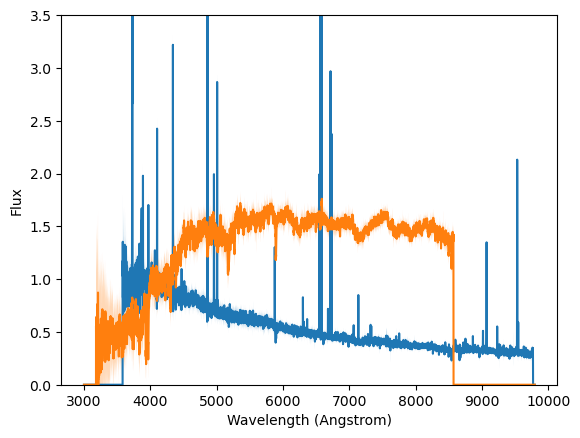

In [13]:
for i in range(2):
    plt.plot(stack_file[3].data, stack_file[1].data[i])
    plt.fill_between(stack_file[3].data, stack_file[1].data[i]-stack_file[2].data[i]**-0.5, stack_file[1].data[i]+stack_file[2].data[i]**-0.5, alpha=0.3)

plt.ylim(0,3.5)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')

/tmp/ipykernel_75913/481060406.py:3: RuntimeWarning: divide by zero encountered in power
  plt.fill_between(stack_file[3].data, stack_file[1].data[i]-stack_file[2].data[i]**-0.5, stack_file[1].data[i]+stack_file[2].data[i]**-0.5, alpha=0.3)


Text(0, 0.5, 'Flux')

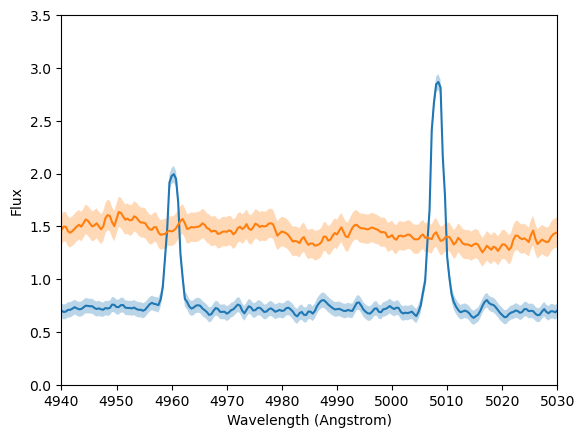

In [14]:
for i in range(2):
    plt.plot(stack_file[3].data, stack_file[1].data[i])
    plt.fill_between(stack_file[3].data, stack_file[1].data[i]-stack_file[2].data[i]**-0.5, stack_file[1].data[i]+stack_file[2].data[i]**-0.5, alpha=0.3)

plt.ylim(0,3.5)
plt.xlim(4940,5030)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')